In [31]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import pickle
import preprocess_library as pre
from scipy import signal
import pywt
import pandas as pd
from scipy import stats
from scipy.integrate import simpson
import mne
from mne.datasets.sleep_physionet.age import fetch_data
import mne
import os
import xml.etree.ElementTree as ET
import numpy as np

In [32]:
# Define patient ID and directories
patient_id = 1
input_dir = 'Input'
# output_dir = 'Output' # Not used in this selection, but was in original pre.load_patient_data call

edf_basename = f'R{patient_id}.edf' # Adjust format as needed
xml_basename = f'R{patient_id}.xml' # Adjust format as needed
edf_file = os.path.join(input_dir, edf_basename)
xml_file = os.path.join(input_dir, xml_basename)

# Define channels to load by name (based on the values in the original dict)
CHANNELS = [
    'EEG(sec)',
    'ECG',
    'EMG',
    'EOG(L)',
    'EOG(R)',
    'EEG',
]

# Load the EDF file using MNE
print(f"Loading EDF file: {edf_file}...")

# preload=True loads data into memory for easier access
# infer_types=True attempts to set channel types based on names (e.g., EEG, EOG)
raw = mne.io.read_raw_edf(
    edf_file,
    include=CHANNELS,
    preload=True,
    infer_types=True,
    verbose=False # Suppress MNE's loading messages for cleaner output
)

raw.set_channel_types({'ECG': 'ecg', 'EEG(sec)': 'eeg', 'EMG': 'emg', 'EOG(L)': 'eog', 'EOG(R)': 'eog'})
print(f"Channels in loaded data: {raw.ch_names}")

# Get sampling frequency from the loaded data's info attribute
FS = int(raw.info['sfreq'])

# Define epoch length in seconds (standard for sleep staging)
EPOCH_SEC_LENGTH = 30
SAMPLES_PER_EPOCH = FS * EPOCH_SEC_LENGTH

# --- Load Hypnogram Data (XML) ---
events, patient_stage, epoch_length, _ = pre.read_xml(xml_file)
stages_per_epoch = len(patient_stage) // 30

print(raw.info)
# - Accessing EEG data: raw.get_data(picks=['EEG'])
# - Accessing channel names: raw.ch_names
# - Accessing sampling rate: raw.info['sfreq'] (or the variable FS)
# - Using sleep stages: patient_stage array

Loading EDF file: Input/R1.edf...


/var/folders/ms/4w4wv0wj50sf19sxrvz26nfw0000gn/T/ipykernel_73629/2993464548.py:26: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(


Channels in loaded data: ['EEG(sec)', 'ECG', 'EMG', 'EOG(L)', 'EOG(R)', 'EEG']
<Info | 8 non-empty values
 bads: []
 ch_names: EEG(sec), ECG, EMG, EOG(L), EOG(R), EEG
 chs: 2 EEG, 1 ECG, 1 EMG, 2 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: unspecified
 nchan: 6
 projs: []
 sfreq: 125.0 Hz
 subject_info: 1 item (dict)
>


In [33]:
# Remove the first and last 30 minutes of data
SECONDS_TO_REMOVE = 30 * 60 # 30 minutes in seconds


# Calculate new start and end times for cropping (in seconds)
tmin_crop = SECONDS_TO_REMOVE
tmax_crop = raw.times[-1] - SECONDS_TO_REMOVE

print(f"Original data duration: {raw.times[-1]:.2f} seconds")
print(f"Attempting to crop data between {tmin_crop}s and {tmax_crop}s")

# Check if the duration allows for cropping
if tmax_crop > tmin_crop:
    # Crop the MNE Raw object in place
    raw.crop(tmin=tmin_crop, tmax=tmax_crop, include_tmax=False) # include_tmax=False is default
    print(f"Cropped raw data. New duration: {raw.times[-1]:.2f} seconds (from {raw.times[0]:.2f}s)")

    # Crop the patient_stage array (assuming it contains one label per second)
    # Convert seconds to integer indices
    start_stage_index = int(round(tmin_crop))
    # Calculate the end index based on the *original* length corresponding to the original duration
    # This assumes patient_stage length matched original_duration_sec before cropping
    end_stage_index = len(patient_stage) - start_stage_index

    if end_stage_index > start_stage_index and start_stage_index >= 0:
        patient_stage = patient_stage[start_stage_index:end_stage_index]
        print(f"Cropped patient_stage array. New length: {len(patient_stage)}")
        # Verify if new stage length matches new duration in seconds
        new_duration_sec = raw.times[-1] # Duration after cropping
        if len(patient_stage) != int(round(new_duration_sec)):
             print(f"Warning: Cropped stage length ({len(patient_stage)}) does not match new data duration ({new_duration_sec:.2f}s).")
    else:
        print(f"Warning: Could not crop patient_stage. Indices invalid or length mismatch (start: {start_stage_index}, end: {end_stage_index}, original len: {len(patient_stage)}).")

    # Recalculate FS and SAMPLES_PER_EPOCH (FS shouldn't change, but good practice)
    FS = int(raw.info['sfreq'])
    SAMPLES_PER_EPOCH = FS * EPOCH_SEC_LENGTH # EPOCH_SEC_LENGTH is 30

    # Calculate the number of full epochs in the cropped data
    NB_EPOCHS = raw.n_times // SAMPLES_PER_EPOCH
    print(f"Number of full {EPOCH_SEC_LENGTH}s epochs after cropping: {NB_EPOCHS}")
    
raw.set_eeg_reference(ref_channels='average', projection=True)



Original data duration: 32519.99 seconds
Attempting to crop data between 1800s and 30719.992s
Cropped raw data. New duration: 28919.98 seconds (from 0.00s)
Cropped patient_stage array. New length: 28890
Number of full 30s epochs after cropping: 963
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<RawEDF | R1.edf, 6 x 3614999 (28920.0 s), ~165.5 MB, data loaded>

In [34]:
raw_data = raw.copy()
filtered_data = raw.filter(l_freq=0.5, h_freq=None, method='fir')
filtered_data.notch_filter(60, method='fir')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 825 samples (6.600 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 825 sample

<RawEDF | R1.edf, 6 x 3614999 (28920.0 s), ~165.5 MB, data loaded>

In [35]:
tmp_eeg_raw = raw_data.get_data(picks=['EEG(sec)'])[0]
print(tmp_eeg_raw)

tmp_eeg_filtered = filtered_data.get_data(picks=['EEG(sec)'])[0]
print(tmp_eeg_filtered)


[-2.89215686e-05 -2.89215686e-05 -2.99019608e-05 ... -7.20588235e-05
 -5.53921569e-05 -1.24019608e-04]
[-1.62392098e-20  3.89697299e-08 -9.56449448e-07 ...  5.57970507e-05
  6.46681424e-05  5.42101086e-20]


(array([2.12379701e-10, 6.05932804e-10, 3.08934524e-10, 1.22152312e-10,
        7.75597259e-11, 5.50134460e-11, 4.11315795e-11, 3.14498696e-11,
        2.48635519e-11, 2.04704194e-11, 1.71617381e-11, 1.49528578e-11,
        1.34139000e-11, 1.22952329e-11, 1.09614284e-11, 1.00895743e-11,
        9.02130198e-12, 9.34882510e-12, 1.04759930e-11, 8.38901941e-12,
        7.77024542e-12, 7.07938633e-12, 6.90783839e-12, 6.71452060e-12,
        6.66880315e-12, 6.33882512e-12, 6.03462375e-12, 1.17633343e-11,
        1.52479109e-10, 1.51127011e-10, 1.04244388e-11, 4.22184199e-12,
        3.99075143e-12, 3.82276643e-12, 3.40505430e-12, 3.19410109e-12,
        3.01796271e-12, 2.86691034e-12, 3.16397549e-12, 5.16097938e-12,
        3.34819171e-12, 2.46616360e-12, 2.45806042e-12, 2.33679394e-12,
        2.29488636e-12, 2.21783050e-12, 2.15758819e-12, 2.12844475e-12,
        2.01717173e-12, 2.17808005e-12, 2.41738203e-12, 2.04022740e-12,
        1.88010660e-12, 1.73000617e-12, 1.70035069e-12, 1.709438

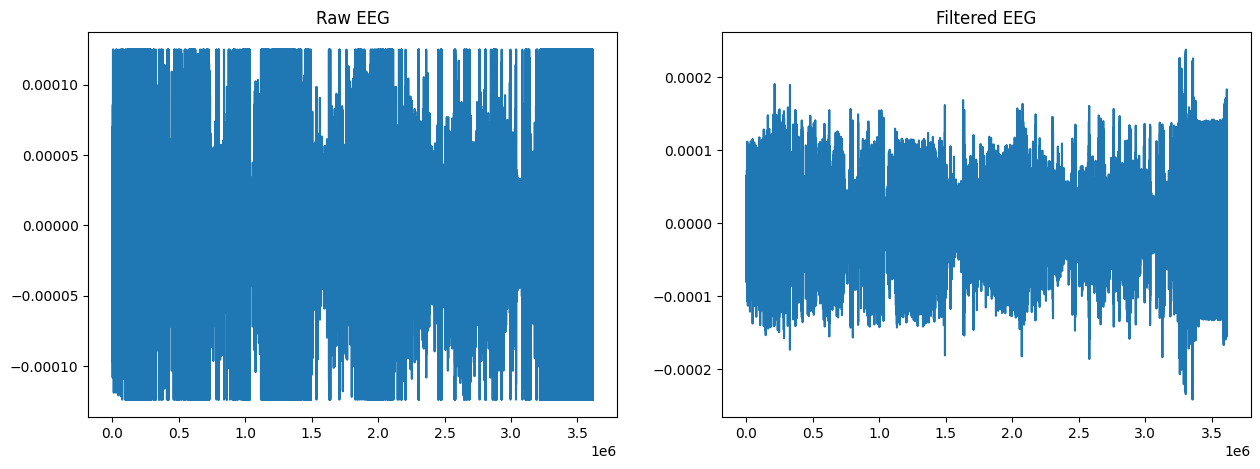

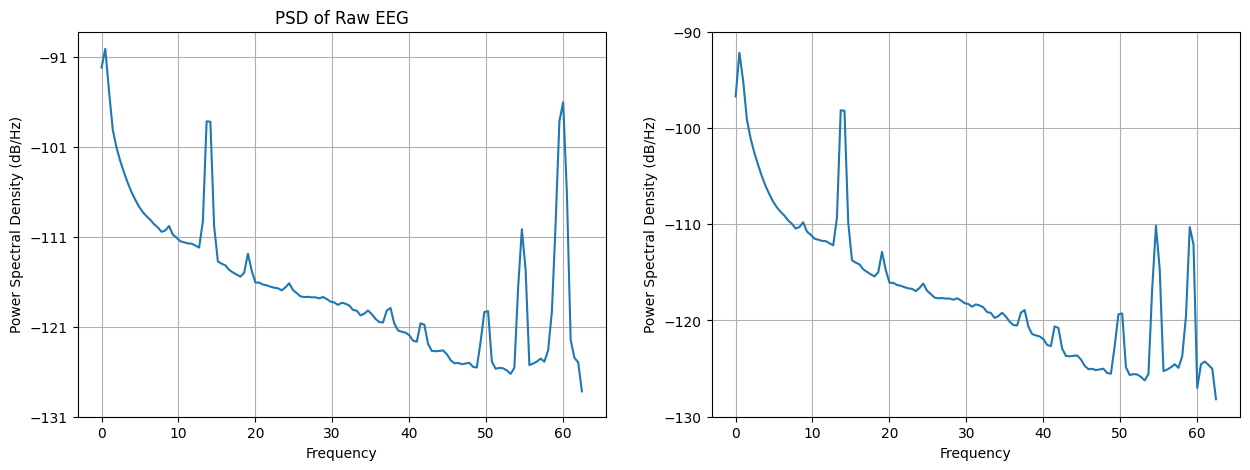

In [36]:
# Plot the raw and filered data of channel EEG(sec)
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(tmp_eeg_raw)
plt.title('Raw EEG')
plt.subplot(1, 2, 2)
plt.plot(tmp_eeg_filtered)
plt.title('Filtered EEG')

# Plot the PSD of the raw and filtered data of channel EEG
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.psd(tmp_eeg_raw, Fs=FS)
plt.title('PSD of Raw EEG')
plt.subplot(1, 2, 2)
plt.psd(tmp_eeg_filtered, Fs=FS)

Effective window size : 16.384 (s)
Plotting power spectral density (dB=True).


/var/folders/ms/4w4wv0wj50sf19sxrvz26nfw0000gn/T/ipykernel_73629/3680574574.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  EEG_psd_fig = filtered_data.compute_psd().plot()
/Users/mariusfauteux/Documents/GitHub/signal-processing-CM2013-ss/EEG-Clasification_V4/.venv/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


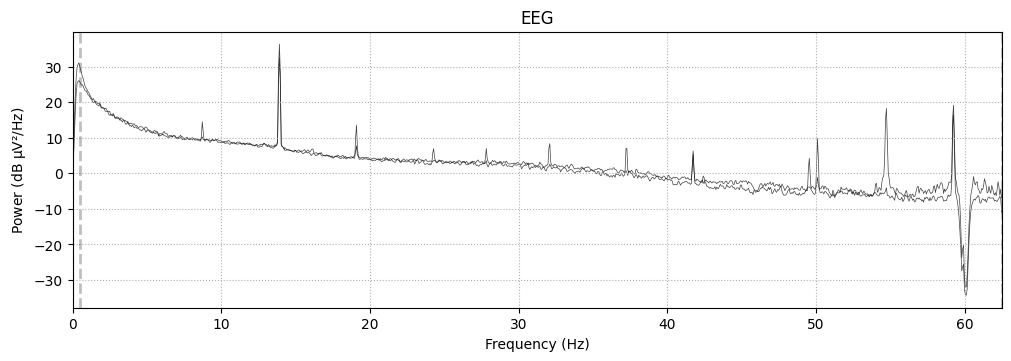

In [37]:
EEG_psd_fig = filtered_data.compute_psd().plot()

In [38]:
weight = mne.preprocessing.EOGRegression().fit(filtered_data)
filtered_data_cleaned = weight.apply(filtered_data, copy=True)

Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


In [39]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

Not setting metadata
963 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 963 events and 3750 original time points ...
0 bad epochs dropped
<Epochs | 963 events (all good), 0 – 29.992 s (baseline off), ~165.3 MB, data loaded,
 '1': 963>


RuntimeError: Valid channel positions are needed for autoreject to work

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
from autoreject import AutoReject

epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs)

reject_log = ar.get_reject_log(epochs)

In [ ]:
ecg_proj, log = mne.preprocessing.compute_proj_ecg(filtered_data_cleaned)

In [ ]:
filtered_data_cleaned.add_proj(ecg_proj)
filtered_data_cleaned.apply_proj()

In [ ]:
tmp = log[:28890,0]//125
print(f'TMP is {tmp}')
print(len(tmp))
print(len(patient_stage))

patient_stage = np.delete(patient_stage, tmp, axis = 0)

In [ ]:
print(patient_stage)

print(len(filtered_data_cleaned)//SAMPLES_PER_EPOCH)

In [ ]:
# The threshold is data dependent, check the optimal threshold by plotting
# ``scores_muscle``.
threshold_muscle = 10  # z-score
# Choose one channel type, if there are axial gradiometers and magnetometers,
# select magnetometers as they are more sensitive to muscle activity.
annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
    filtered_data_cleaned,
    ch_type="eeg",
    threshold=threshold_muscle,
    min_length_good=0.2,
    filter_freq=[30, 60],
)

fig, ax = plt.subplots()
ax.plot(filtered_data_cleaned.times, scores_muscle)
ax.axhline(y=threshold_muscle, color="r")
ax.set(xlabel="time, (s)", ylabel="zscore", title="Muscle activity")

In [ ]:
filtered_data_cleaned.set_annotations(annot_muscle)
plt = filtered_data_cleaned.plot(start=5, duration=20)

plt = raw_data.plot(start=5, duration=20)

In [ ]:
epochs = mne.make_fixed_length_epochs(filtered_data_cleaned, duration=30, preload=True)
print(epochs)

In [ ]:
patient_epoch = {} # Initialize as a dictionary

# Process each channel
for channel_idx, channel_name in channels.items():
    # Get the channel data for this patient
    channel_data = filtered_data[channel_name]

    # Create a list to store all epochs for this channel
    channel_epochs = []

    # Split the data into epochs
    for epoch_idx in range(NB_EPOCHS):
        start_idx = epoch_idx * SAMPLES_PER_EPOCH
        end_idx = start_idx + SAMPLES_PER_EPOCH
        epoch_data = channel_data[start_idx:end_idx]
        channel_epochs.append(epoch_data)

    # Store all epochs for this channel in the patient's dictionary
    patient_epoch[channel_name] = channel_epochs

    print(f"  - Channel {channel_name}: Created {len(channel_epochs)} epochs of length {SAMPLES_PER_EPOCH}")